In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PreProcess

In [2]:
import os
import random
import librosa
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Sampler
from torch.nn.utils.rnn import pad_sequence

class PaddedBatchSampler(Sampler):
    """最後のバッチを指定サイズまで補完するサンプラー"""

    def __init__(self, dataset_size, batch_size):
        self.dataset_size = dataset_size
        self.batch_size = batch_size

    def __iter__(self):
        # 通常のインデックス
        indices = list(range(self.dataset_size))

        # 最後のバッチを補完するために必要なサンプル数を計算
        remainder = self.dataset_size % self.batch_size
        padding_size = 0 if remainder == 0 else self.batch_size - remainder

        # 不足分は既存のデータからランダムに選んで補完
        if padding_size > 0:
            padding_indices = random.choices(indices, k=padding_size)
            indices = indices + padding_indices

        # インデックスをシャッフル
        random.shuffle(indices)
        return iter(indices)

    def __len__(self):
        # バッチサイズで割り切れるサンプル数を返す
        padding_size = 0 if self.dataset_size % self.batch_size == 0 else self.batch_size - (self.dataset_size % self.batch_size)
        return self.dataset_size + padding_size

class AudioPreprocessor:
    def __init__(self):
        self.sample_rate = 22050
        self.segment_length = 2 * self.sample_rate  # 2秒分のサンプル数
        self.min_length = int(1.5 * self.sample_rate)  # 1.5秒分のサンプル数
        #メルスペクトログラムの出力の高さ（次元数）
        self.n_mels = 128
        self.hop_length = 512
        # self.time_frames = self.segment_length // self.hop_length
        #generaterへの入力値となる。
        # ノイズの数「どれだけ多様な出力を生み出せるか」に影響する潜在空間の次元数
        self.n_noise = 256
        # self.n_mid_1 = 1024
        # self.n_mid_2 = 2048
        # self.n_mid_3 = 4096
        # self.n_z = 32
        self.epochs = 200
        self.interval = 10
        self.n_fft = 2048
        self.min_db = -80.0
        self.max_db = 0.0

    def load_audio(self, file_name):
        """音声ファイルをロード"""
        file_path = os.path.join(self.audio_path, file_name)
        audio, _ = librosa.load(file_path, sr=self.sample_rate)
        return audio

    def adjust_segment(self, audio):
        """音声データを2秒ごとに区切り、必要に応じてゼロパディング"""
        segments = []
        for i in range(0, len(audio), self.segment_length):
            segment = audio[i:i + self.segment_length]
            if len(segment) == self.segment_length:
                segments.append(segment)
            elif len(segment) >= self.min_length:
                # 1.5秒以上の場合はゼロパディング
                padded_segment = np.pad(segment, (0, self.segment_length - len(segment)), mode='constant')
                segments.append(padded_segment)
        return segments

    def preprocess_audio(self, audio):
        """音声データをメルスペクトログラムに変換"""
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=self.sample_rate, n_mels=self.n_mels, hop_length=self.hop_length, n_fft=self.n_fft
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = np.clip(mel_spec_db, self.min_db, self.max_db)
        mel_spec_db = 2 * (mel_spec_db - self.min_db) / (self.max_db - self.min_db) - 1

        return mel_spec_db

    def process_all_files(self, audio_path):
        """ディレクトリ内のすべての音声ファイルを処理し、メルスペクトログラムを返す"""
        self.audio_path = audio_path
        all_mel_specs = []
        for file_name in os.listdir(audio_path):
            if file_name.endswith('.wav'):
                print(f"Processing {file_name}...")
                audio = self.load_audio(file_name)
                segments = self.adjust_segment(audio)
                mel_specs = [self.preprocess_audio(segment) for segment in segments]
                all_mel_specs.extend(mel_specs)
        print("All files processed.")
        return all_mel_specs

    def collate_fn(self, batch):
        # batch is a list of tuples (mel_spec)
        mel_specs = [item[0] for item in batch]

        # デバッグ情報（オプション）
        # print(f"バッチ内のサンプル数: {len(mel_specs)}")
        # for i, spec in enumerate(mel_specs):
        #     print(f"スペクトログラム {i} の形状: {spec.shape}")

        # Pad mel_specs to the maximum length in the batch
        mel_specs_padded = pad_sequence(mel_specs, batch_first=True)
        return (mel_specs_padded,)

    def create_dataloader(self, mel_specs, batch_size=16):
        """メルスペクトログラムからデータローダーを作成（最後のバッチも補完）"""
        mel_specs_array = np.array(mel_specs)
        mel_specs_tensor = torch.tensor(mel_specs_array, dtype=torch.float)
        dataset = torch.utils.data.TensorDataset(mel_specs_tensor)

        # カスタムサンプラーを使用して不足分を補完
        sampler = PaddedBatchSampler(len(dataset), batch_size)

        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=sampler,  # samplerを指定するとshuffleは無視される
            collate_fn=self.collate_fn
        )

        # データセットのサイズとバッチサイズから最後のバッチが何個になるか計算
        num_samples = len(dataset)
        num_complete_batches = num_samples // batch_size
        remaining_samples = num_samples % batch_size

        print(f"データセットサイズ: {num_samples}")
        print(f"完全なバッチ数: {num_complete_batches}")
        if remaining_samples > 0:
            print(f"最後のバッチのサンプル数: {remaining_samples} (補完して {batch_size} になります)")
        else:
            print("すべてのバッチが完全です")

        return dataloader

    def get_trainloder(self):
        self.audio_path = "/content/drive/MyDrive/Colab_Notebooks/VAESound/inputAudio"

        mel_specs = self.process_all_files(self.audio_path)
        print(f"処理されたメルスペクトログラムの数: {len(mel_specs)}")

        # データローダーを作成（補完機能付き）
        dataloader = self.create_dataloader(mel_specs, batch_size=16)

        # データローダーの確認
        #タプル (tensor,)（要素数1のタプル） になっている。
        for batch in dataloader:
            print(f"バッチの形状1: {batch[0].shape}")
            x = batch[0]  # batch は (tensor,) のタプル
            total_elements = x.shape[1] * x.shape[2]  # 128 * 87 = 11136
            break


        self.time_frames = x.shape[2]
        print(f"バッチの形状2: {x.shape}")

        print(f"バッチ内の総要素数: {total_elements}")



        return dataloader, total_elements


# 使用例
preprocessor = AudioPreprocessor()
train_loader, n_in_out = preprocessor.get_trainloder()

Processing 60note50.wav...
Processing 60note37.wav...
Processing 60note102.wav...
Processing 60note78.wav...
Processing 60note21.wav...
Processing 60note43.wav...
Processing 60note31.wav...
Processing 60note94.wav...
Processing 60note97.wav...
Processing 60note101.wav...
Processing 60note91.wav...
Processing 60note105.wav...
Processing 60note85.wav...
Processing 60note103.wav...
Processing 60note92.wav...
Processing 60note56.wav...
Processing 60note45.wav...
Processing 60note84.wav...
Processing 60note80.wav...
Processing 60note100.wav...
Processing 60note9.wav...
Processing 60note35.wav...
Processing 60note83.wav...
Processing 60note19.wav...
Processing 60note87.wav...
Processing 60note20.wav...
Processing 60note34.wav...
Processing 60note47.wav...
Processing 60note79.wav...
Processing 60note33.wav...
Processing 60note18.wav...
Processing 60note86.wav...
Processing 60note57.wav...
Processing 60note36.wav...
Processing 60note68.wav...
Processing 60note8.wav...
Processing 60note110.wav.

# Generator


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #だんだんニューロン数はおおきくなる。
        #通常のGAN
        # self.mid_1 = nn.Linear(preprocessor.n_noise, preprocessor.n_mid_1)
        # self.mid_2 = nn.Linear(preprocessor.n_mid_1, preprocessor.n_mid_2)
        # self.mid_3 = nn.Linear(preprocessor.n_mid_2, preprocessor.n_mid_3)
        # self.out = nn.Linear(preprocessor.n_mid_3, n_in_out)

        #DCGAN インプットサイズ𝑊、カーネルサイズ𝐾、パディングｐ、ストライドsの場合、((𝑊−1)×𝑠−𝑝×2+𝐾)
         # 入力ノイズから始めて、逆畳み込み操作で徐々に拡大
        # 初期サイズを計算して逆に進む: 128/32=4, 87/32≈2.7→3
        # よって開始サイズは 4x3

        # プロジェクション層 - ノイズベクトルから小さな特徴マップを作成
        self.projection = nn.Linear(preprocessor.n_noise, 256 * 4 * 3)
        self.bn_proj = nn.BatchNorm1d(256 * 4 * 3)

        # 畳み込み転置層による拡大
        # 4x3 → 8x6
        self.convt1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(128)

        # 8x6 → 16x11 ((6 - 1)* 2 - 0 + 3) = 13
        self.convt2 = nn.ConvTranspose2d(128, 64, kernel_size=(4, 3), stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # 16x11 → 32x22
        self.convt3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        # 32x22 → 64x44
        self.convt4 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(16)

        # 64x44 → 128x87 (目標サイズ)  ((44-1)*2-0+3)=
        self.convt5 = nn.ConvTranspose2d(16, 1, kernel_size=(4, 3), stride=2, padding=1)

    def forward(self, x):
        #通常のGAN
        # x = F.relu(self.mid_1(x))
        # x = F.relu(self.mid_2(x))
        # x = F.relu(self.mid_3(x))
        # x = F.tanh(self.out(x))

        #DCGAN
        # print(f"Input shape Generator: {x.shape}")

        # Linear に入れる前に 2次元に flatten
        x = x.view(-1, preprocessor.n_noise)  # [batch_size, n_noise]
        # print(f"x = x.view(-1, n_noise): {x.shape}")

        # プロジェクション & リシェイプ
        x = self.projection(x)                # [batch_size, 256*4*3]
        x = self.bn_proj(x)
        x = F.relu(x)
        x = x.view(-1, 256, 4, 3)             # [batch_size, 256, 4, 3]

        # 逆畳み込み層による段階的なアップサンプリング
        x = F.relu(self.bn1(self.convt1(x)))  # [batch_size, 128, 8, 6]
        # print(f"1: {x.shape}")
        x = F.relu(self.bn2(self.convt2(x)))  # [batch_size, 64, 16, 11]
        # print(f"2: {x.shape}")
        x = F.relu(self.bn3(self.convt3(x)))  # [batch_size, 32, 32, 22]
        # print(f"3: {x.shape}")
        x = F.relu(self.bn4(self.convt4(x)))  # [batch_size, 16, 64, 44]
        # print(f"4: {x.shape}")

        # 最終層 - tanh活性化関数で出力を[-1, 1]に制限
        x = torch.tanh(self.convt5(x))        # [batch_size, 1, 128, 87]
        # print(f"5: {x.shape}")
        return x

generator = Generator()
generator.cuda()  # GPU対応
print(generator)

Generator(
  (projection): Linear(in_features=256, out_features=3072, bias=True)
  (bn_proj): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt2): ConvTranspose2d(128, 64, kernel_size=(4, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt5): ConvTranspose2d(16, 1, kernel_size=(4, 3), stride=(2, 2), padding=(1, 1))
)


# Discriminator

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #だんだんニューロン数は小さくなる。
        #通常のGAN
        # self.mid_1 = nn.Linear(n_in_out, preprocessor.n_mid_3)
        # self.mid_2 = nn.Linear(preprocessor.n_mid_3, preprocessor.n_mid_2)
        # self.mid_3 = nn.Linear(preprocessor.n_mid_2, preprocessor.n_mid_1)
        # self.out = nn.Linear(preprocessor.n_mid_1, 1)

        #DCGAN ((𝑊+{𝑝×2}−𝐾)/𝑠+1)
         # 畳み込み層で特徴抽出してダウンサンプリング
         #DCGAN論文では、最初の層以外のDiscriminator層にBatchNormが推奨
        # 128x87 → 64x43　 ((87 + 2 - 4) / 2 + 1)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1)
        # LeakyReLUのみ（最初の層にはBatchNormを適用しない - DCGAN論文推奨）

        # 64x43 → 32x21　torch.Size([16, 32, 32, 26])
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # 32x21 → 16x10
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # 16x10 → 8x5
        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # 8x5 → 4x2
        self.conv5 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        # 最終判定層 - 4x2 → 1x1
        self.conv6 = nn.Conv2d(256, 1, kernel_size=(4, 2), stride=1, padding=0)

        # ドロップアウト（オプション - モデルの安定性向上）
        self.dropout = nn.Dropout2d(0.3)


    def forward(self, x):
      #１次元に変換する。
        #通常のGAN
        # x = x.view(x.size(0), -1)
        # x = F.leaky_relu(self.mid_1(x), negative_slope=0.2)
        # x = F.leaky_relu(self.mid_2(x), negative_slope=0.2)
        # x = F.leaky_relu(self.mid_3(x), negative_slope=0.2)
        # x = F.sigmoid(self.out(x))

        #DCGAN
        x = x.view(x.size(0), 1, preprocessor.n_mels, -1)  # (バッチサイズ, チャンネル数, 高さ, 幅)
        # print(f"Input shape Discriminator: {x.shape}")

        # 畳み込み層を通したダウンサンプリング
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        # print(f"After conv1: {x.shape}")

        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        # print(f"After conv2: {x.shape}")

        # ドロップアウトを追加（オプション）
        x = self.dropout(x)

        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        # print(f"After conv3: {x.shape}")

        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        # print(f"After conv4: {x.shape}")

        x = F.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.2)
        # print(f"After conv5: {x.shape}")

        # 最終層 - シグモイド活性化で0-1の確率を出力
        x = torch.sigmoid(self.conv6(x))
        # print(f"After conv6: {x.shape}")

       # バッチサイズ x 1 の形状に変形
        x = x.view(-1, 1)
        # print(f"Final output: {x.shape}")
        return x

discriminator = Discriminator()
discriminator.cuda()  # GPU対応
print(discriminator)

Discriminator(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 1, kernel_size=(4, 2), stride=(1, 1))
  (dropout): Dropout2d(p=0.3, inplace=False)
)


# Generate Noise


In [5]:
import matplotlib.pyplot as plt
# -- 画像を生成して表示 --
def generate_images(i):
    # 画像の生成
    n_rows = 4  # 行数
    n_cols = 4  # 列数
    noise = torch.randn(n_rows * n_cols, preprocessor.n_noise).cuda()
    g_imgs = generator(noise)
    g_imgs = g_imgs/2 + 0.5  # 0-1の範囲にする
    g_imgs = g_imgs.cpu().detach().numpy()

    time_frames_spaced = preprocessor.time_frames + 2
    n_mels_spaced = preprocessor.n_mels + 2


    matrix_image = np.zeros((time_frames_spaced*n_rows, n_mels_spaced*n_cols))  # 全体の画像

    #  生成された画像を並べて一枚の画像にする
    for r in range(n_rows):
        for c in range(n_cols):
          #時間×周波数分解度に変換
            g_img = g_imgs[r*n_cols + c].reshape(preprocessor.time_frames, preprocessor.n_mels)
            top = r*time_frames_spaced
            left = c*n_mels_spaced
            matrix_image[top : top+preprocessor.time_frames, left : left+preprocessor.n_mels] = g_img

    plt.figure(figsize=(8, 8))
    plt.imshow(matrix_image, cmap="Greys_r", vmin=0.0, vmax=1.0)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # 軸目盛りのラベルと線を消す
    plt.show()


#正解数の計算
def count_correct(y, t):
    correct = torch.sum((torch.where(y<0.5, 0, 1) ==  t).float())
    return correct.item()

# Train

In [6]:
!pip install onnx onnxruntime
import torch.onnx
from torch import optim

def trainModel():
  # 二値の交差エントロピー誤差関数
  loss_func = nn.BCELoss()

  # Adam betas=(0.5, 0.999) は Adam オプティマイザのハイパーパラメータで、指数移動平均の減衰率を指定するもの
  optimizer_gen = optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
  optimizer_disc = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

  # ログ
  error_record_fake = []  # 偽物画像の誤差記録
  acc_record_fake = []  # 偽物画像の精度記録
  error_record_real = []  # 本物画像の誤差記録
  acc_record_real = []  # 本物画像の精度記録

  # -- GANの学習 --
  generator.train()
  discriminator.train()
  for i in range(preprocessor.epochs):
      loss_fake = 0  # 誤差
      correct_fake = 0  # 正解数
      loss_real = 0
      correct_real = 0
      n_total = 0  # データの総数（精度の計算に使用）
      for j, (x,) in enumerate(train_loader):  # ミニバッチ（x,）を取り出す

          # print("x max:", x.max().item(), "x min:", x.min().item())

          n_total += x.size()[0]  # バッチサイズを累積

          # ノイズから画像を生成しDiscriminatorを訓練
          noise = torch.randn(x.size()[0], preprocessor.n_noise).cuda()


          imgs_fake = generator(noise)  # 画像の生成
          t = torch.zeros(x.size()[0], 1).cuda()  # 正解は0


          # print("first")
          y = discriminator(imgs_fake)

          # print("y ", y.shape)
          # print("t ", t.shape)
          loss = loss_func(y, t)
          optimizer_disc.zero_grad()
          loss.backward()
          optimizer_disc.step()  # Discriminatorのみパラメータを更新
          loss_fake += loss.item()
          correct_fake += count_correct(y, t)

          # 本物の画像を使ってDiscriminatorを訓練
          imgs_real= x.cuda()
          t = torch.ones(x.size()[0], 1).cuda()  # 正解は1

          # print("second")
          y = discriminator(imgs_real)
          loss = loss_func(y, t)
          optimizer_disc.zero_grad()
          loss.backward()
          optimizer_disc.step()  # Discriminatorのみパラメータを更新
          loss_real += loss.item()
          correct_real += count_correct(y, t)

          # Generatorを訓練
          noise = torch.randn(x.size()[0]*2, preprocessor.n_noise).cuda()  # バッチサイズを2倍にする
          imgs_fake = generator(noise)  # 画像の生成
          t = torch.full((x.size()[0]*2, 1), 0.9).cuda()  # 本物っぽいけどちょっと曖昧
          # print("third")
          y = discriminator(imgs_fake)
          loss = loss_func(y, t)
          optimizer_gen.zero_grad()
          loss.backward()
          optimizer_gen.step()  # Generatorのみパラメータを更新

      loss_fake /= j+1  # 誤差
      error_record_fake.append(loss_fake)
      acc_fake = correct_fake / n_total  # 精度
      acc_record_fake.append(acc_fake)

      loss_real /= j+1  # 誤差
      error_record_real.append(loss_real)
      acc_real = correct_real / n_total  # 精度
      acc_record_real.append(acc_real)

      # 一定間隔で誤差と精度、および生成された画像を表示
      if i % preprocessor.interval == 0:
          print ("Epochs:", i)
          # 生成された画像（偽物）に対するDiscriminatorの誤差,精度
          print ("Error_fake:", loss_fake , "Acc_fake:", acc_fake)
          #本物の画像に対するDiscriminatorの誤差、精度
          print ("Error_real:", loss_real , "Acc_real:", acc_real)
          generate_images(i)

     # 訓練済みモデルを保存
  torch.save(generator.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/GANSound/model/generator.pth")  # generatorを保存
  torch.save(discriminator.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/GANSound/model/discriminator.pth")  # discriminatorを保存

  #export as onnx model
  generator.eval()
  dummy_input = torch.randn(1, preprocessor.n_noise).cuda()
  torch.onnx.export(generator,
                    dummy_input,
                    "/content/drive/MyDrive/Colab_Notebooks/GANSound/model/generator.onnx",
                    export_params=True,
                    opset_version=10,
                    do_constant_folding=True, # 定数畳み込み最適化
                    input_names = ['input'],
                    output_names = ['output'],
                    dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}})
  print("モデルを保存しました。")


if __name__ == "__main__":
    trainModel()

Output hidden; open in https://colab.research.google.com to view.

# Inference

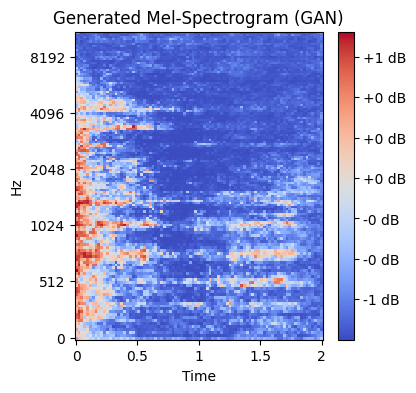

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from IPython.display import display, Audio

def inference_gan():
    # Generator モデルの準備
    generator = Generator()
    generator.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/GANSound/model/generator.pth", map_location="cpu"))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    generator.eval()

    # ハイパーパラメータ（VAEと同様）
    n_noise = preprocessor.n_noise
    n_mels = preprocessor.n_mels
    sample_rate = preprocessor.sample_rate
    hop_length = preprocessor.hop_length
    n_fft = preprocessor.n_fft
    min_db = preprocessor.min_db
    max_db = preprocessor.max_db
    time_frames = preprocessor.time_frames

    # ノイズから潜在変数を生成し、音声生成
    z = torch.randn(1, n_noise).to(device)
    # print("潜在変数 z:", z)

    # Generator でメルスペクトログラム生成
    with torch.no_grad():
        y = generator(z).cpu().numpy()

    # 形状が [batch, channels, mel, time] の場合は reshape
    image = y.reshape(n_mels, time_frames)

    # メルスペクトログラムを表示
    plt.figure(figsize=(4, 4))
    librosa.display.specshow(image, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format="%+2.0f dB")
    plt.title("Generated Mel-Spectrogram (GAN)")
    plt.show()

    # メルスペクトログラムを音声に変換（dBスケール → パワースペクトル）
    mel_spec_db = image * (max_db - min_db) + min_db
    mel_spec = librosa.db_to_power(mel_spec_db)

    # Griffin-Lim による音声復元
    audio = librosa.feature.inverse.mel_to_audio(
        mel_spec,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_iter=32
    )

    audio = audio / (np.max(np.abs(audio)) + 1e-8)

    # 音を再生
    audio_obj = Audio(audio, rate=sample_rate)
    display(audio_obj)

    # 保存
    sf.write("/content/drive/MyDrive/Colab_Notebooks/GANSound/outputAuido/generated_gan_audio.wav", audio, sample_rate)
    # print("GANによって生成された音声を保存しました。")

if __name__ == "__main__":
    inference_gan()
